In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE





from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')



In [2]:
def wrangle(filepath):

    #read csv
    data = pd.read_csv(filepath)

    #drop unnecessary "other" rows
    data = data.drop(data[data["gender"] == "Other"].index)

    #fill bmi missing values with median
    data['bmi'].fillna(data['bmi'].median(), inplace=True)


    #drop id column
    data = data.drop(columns=["id"])

    return data

    

In [3]:
df = wrangle("healthcare-dataset-stroke-data.csv")

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [5]:
df.bmi.describe() 

count    5109.000000
mean       28.863300
std         7.699785
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [6]:
# Label encoding mappings for categorical features except for 'hypertension' and 'heart_disease'

gender_mapping = {'Male': 0, 'Female': 1}

ever_married_mapping = {'No': 0, 'Yes': 1}

residence_type_mapping = {'Rural': 0, 'Urban': 1}

work_type_mapping = {
    'Private': 0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}

smoking_status_mapping = {
    'never smoked': 0,
    'formerly smoked': 1,
    'smokes': 2,
    'Unknown': 3
}


In [7]:
# Apply the mappings to the DataFrame 'df'
df['gender'] = df['gender'].map(gender_mapping)
df['ever_married'] = df['ever_married'].map(ever_married_mapping)
df['Residence_type'] = df['Residence_type'].map(residence_type_mapping)
df['work_type'] = df['work_type'].map(work_type_mapping)
df['smoking_status'] = df['smoking_status'].map(smoking_status_mapping)


In [8]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,1,1
1,1,61.0,0,0,1,1,0,202.21,28.1,0,1
2,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,1,49.0,0,0,1,0,1,171.23,34.4,2,1
4,1,79.0,1,0,1,1,0,174.12,24.0,0,1


In [9]:
target = "stroke"
X = df.drop(target, axis=1)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5109, 10)
y shape: (5109,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4087, 10)
y_train shape: (4087,)
X_test shape: (1022, 10)
y_test shape: (1022,)


# Build model
### Baseline

In [11]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9542


# Resample

In [12]:
#Randpom under sampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(374, 10)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4712,0,57.0,0,0,1,0,1,93.04,29.2,0
3668,1,25.0,0,0,1,0,0,81.21,37.9,0
3974,0,52.0,1,0,1,0,0,100.71,37.0,0
2324,1,63.0,0,0,1,1,1,65.71,29.2,2
552,0,52.0,0,0,1,0,1,247.69,35.1,3


In [13]:
y_train_under.value_counts(normalize=True)

stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

In [14]:
#Random over sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(7800, 10)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,79.0,0,0,1,1,0,112.64,28.5,1
1,1,62.0,0,0,1,0,1,88.32,36.3,3
2,1,21.0,0,0,0,0,0,59.52,33.7,0
3,0,31.0,0,0,1,2,1,65.70,30.4,1
4,1,31.0,0,0,0,0,0,59.63,19.9,0


In [15]:
y_train_over.value_counts(normalize=True)

stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

In [16]:
#Smote sampling
sm = SMOTE(random_state=42) 
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print(X_train_sm.shape)
X_train_sm.head()

(7800, 10)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,0,79.0,0,0,1,1,0,112.64,28.5,1
1,1,62.0,0,0,1,0,1,88.32,36.3,3
2,1,21.0,0,0,0,0,0,59.52,33.7,0
3,0,31.0,0,0,1,2,1,65.70,30.4,1
4,1,31.0,0,0,0,0,0,59.63,19.9,0


In [17]:
y_train_sm.value_counts(normalize=True)

stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

# Iterate

# Decision Tree

In [18]:

# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    DecisionTreeClassifier(random_state=42))
model_reg.fit(X_train, y_train)

#fit on `X_train_sm`, `y_train_sm` smote
model_sm = make_pipeline(
    DecisionTreeClassifier(random_state=42))
model_sm.fit(X_train_sm, y_train_sm)

# Fit on `X_train_under`, `y_train_under` Random under sampling
model_under = make_pipeline(
    DecisionTreeClassifier(random_state=42))
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`, Random over sampling
model_over = make_pipeline(
    DecisionTreeClassifier(random_state=42))
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [19]:
for m in [model_reg, model_sm, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)
    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9168
Training Accuracy: 1.0
Test Accuracy: 0.8659
Training Accuracy: 0.6719
Test Accuracy: 0.6419
Training Accuracy: 1.0
Test Accuracy: 0.9129


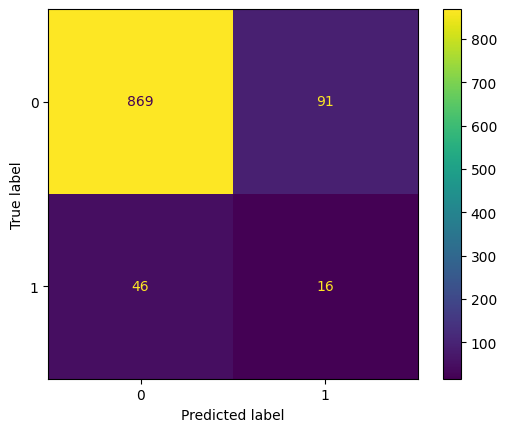

In [20]:
# Plot confusion matrix for best model
ConfusionMatrixDisplay.from_estimator(model_sm, X_test, y_test)

# Communicate

Text(0.5, 1.0, 'model_over Feature Importance')

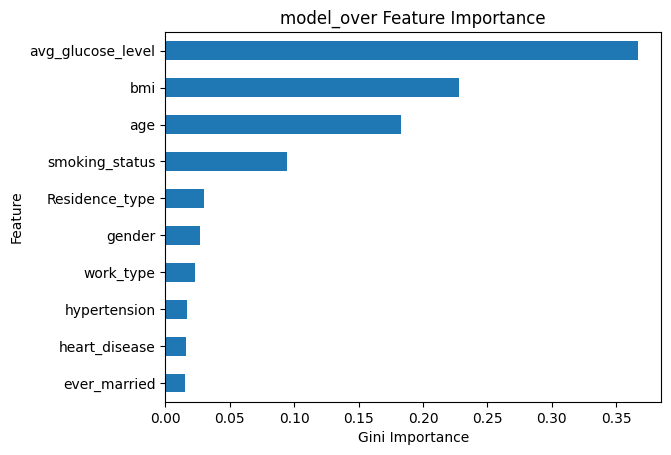

In [21]:
# Get importances
importances = model_reg.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance")

# Random Forest


In [22]:
clf = RandomForestClassifier(random_state=42)
print(clf)

RandomForestClassifier(random_state=42)


In [23]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores) #dont use

cv_acc_scores = cross_val_score(clf, X_train_under, y_train_under, cv=5, n_jobs=-1)
print(cv_acc_scores) #dont use

cv_acc_scores = cross_val_score(clf, X_train_sm, y_train_sm, cv=5, n_jobs=-1)
print(cv_acc_scores) #dont use

[0.99551282 0.99358974 0.99551282 0.98782051 0.99230769]
[0.73333333 0.74666667 0.78666667 0.78666667 0.81081081]
[0.90641026 0.95192308 0.94615385 0.95641026 0.95705128]


In [24]:
params = {
    'n_estimators': range(25, 100, 25),
    'max_depth': range(5, 30, 5)
}
params

{'n_estimators': range(25, 100, 25), 'max_depth': range(5, 30, 5)}

In [25]:
rf_model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1)
rf_model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 30, 5),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [26]:
clf_reg = rf_model.fit(X_train,y_train)
clf_sm = rf_model.fit(X_train_sm,y_train_sm)
clf_under = rf_model.fit(X_train_under,y_train_under)
clf_over = rf_model.fit(X_train_over,y_train_over)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [27]:
cv_results = pd.DataFrame(rf_model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.164813,0.018894,0.008218,0.000109,5,25,"{'max_depth': 5, 'n_estimators': 25}",0.817949,0.809615,0.793590,0.808333,0.830128,0.811923,0.012017,15
1,0.313409,0.012379,0.014569,0.004512,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.823077,0.812821,0.801923,0.814103,0.826923,0.815769,0.008729,13
2,0.461119,0.023699,0.017293,0.003881,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.821795,0.807051,0.796795,0.812821,0.822436,0.812179,0.009603,14
3,0.220938,0.010794,0.012929,0.003192,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.947436,0.937821,0.932051,0.946154,0.944872,0.941667,0.005847,12
4,0.409050,0.010620,0.017152,0.004657,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.951923,0.944231,0.936538,0.950641,0.948077,0.946282,0.005535,11
5,0.621228,0.018758,0.024815,0.005237,10,75,"{'max_depth': 10, 'n_estimators': 75}",0.953205,0.946795,0.937179,0.952564,0.951923,0.948333,0.006022,10
6,0.220715,0.007724,0.013034,0.003938,15,25,"{'max_depth': 15, 'n_estimators': 25}",0.986538,0.985897,0.985256,0.982051,0.985256,0.985000,0.001549,9
7,0.459583,0.018538,0.021878,0.005931,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.990385,0.983974,0.987179,0.983333,0.984615,0.985897,0.002596,8
8,0.671017,0.021950,0.026884,0.005706,15,75,"{'max_depth': 15, 'n_estimators': 75}",0.991026,0.987821,0.989103,0.984615,0.985256,0.987564,0.002385,7
9,0.237540,0.013555,0.010912,0.003275,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.992308,0.993590,0.991667,0.985256,0.991026,0.990769,0.002884,6


In [28]:
mask = cv_results["param_max_depth"] == 20
cv_results[mask]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.237540,0.013555,0.010912,0.003275,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.992308,0.993590,0.991667,0.985256,0.991026,0.990769,0.002884,6
10,0.476068,0.020263,0.021223,0.004209,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.992949,0.994231,0.994231,0.990385,0.990385,0.992436,0.001739,3
11,0.630533,0.061790,0.023109,0.004103,20,75,"{'max_depth': 20, 'n_estimators': 75}",0.991667,0.993590,0.992949,0.991026,0.991667,0.992179,0.000942,4


Text(0.5, 1.0, 'Training Time vs Estimators (max_depth=30)')

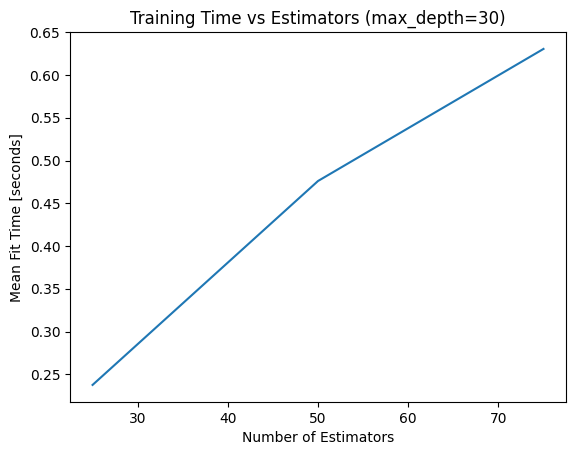

In [29]:
# Create mask
mask = cv_results["param_max_depth"] == 20
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_n_estimators"],
    cv_results[mask]["mean_fit_time"]
)

# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=30)")

In [30]:
# Extract best hyperparameters
rf_model.best_params_

{'max_depth': 25, 'n_estimators': 50}

In [31]:
rf_model.best_score_

0.9929487179487179

In [32]:
rf_model.best_estimator_

RandomForestClassifier(max_depth=25, n_estimators=50, random_state=42)

In [33]:
for rf_model in [clf_reg, clf_sm, clf_under, clf_over]:
    acc_train = rf_model.score(X_train, y_train)
    acc_test = rf_model.score(X_test, y_test)
    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9354
Training Accuracy: 1.0
Test Accuracy: 0.9354
Training Accuracy: 1.0
Test Accuracy: 0.9354
Training Accuracy: 1.0
Test Accuracy: 0.9354


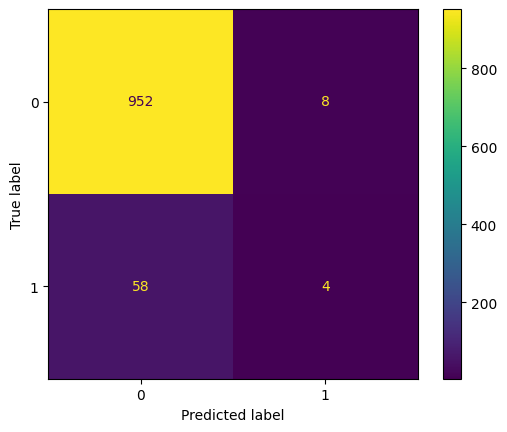

In [34]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

In [35]:
importances = rf_model.best_estimator_.feature_importances_


Text(0.5, 1.0, 'Feature Importance')

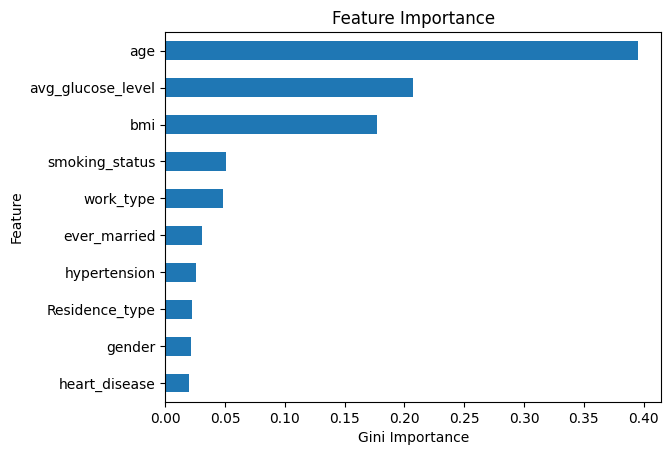

In [36]:
features = X_train_over.columns
# Extract importances from model
importances = rf_model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")

# Gradient Boosting Classifier

In [37]:
# Gradient Boosting Classifier

clf = GradientBoostingClassifier(random_state=42)

In [38]:
params = {
    "n_estimators": range(20, 31, 2),
    "max_depth": range(2, 10)
}
params

{'n_estimators': range(20, 31, 2), 'max_depth': range(2, 10)}

In [39]:
gb_model = GridSearchCV(clf,
                    param_grid=params,
                    cv=5,
                    n_jobs=-1,
                    verbose=1
                    )

In [40]:
clf_reg_gb = gb_model.fit(X_train,y_train)
clf_sm_gb = gb_model.fit(X_train_sm,y_train_sm)
clf_under_gb = gb_model.fit(X_train_under,y_train_under)
clf_over_gb = gb_model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [41]:
results = pd.DataFrame(gb_model.cv_results_)
results.sort_values("rank_test_score").tail(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.345099,0.018950,0.003397,0.004019,3,30,"{'max_depth': 3, 'n_estimators': 30}",0.813462,0.805769,0.796795,0.801923,0.826282,0.808846,0.010276,38
8,0.274387,0.009422,0.006471,0.003238,3,24,"{'max_depth': 3, 'n_estimators': 24}",0.819872,0.801282,0.793590,0.798077,0.818590,0.806282,0.010859,40
7,0.256650,0.014533,0.006214,0.003205,3,22,"{'max_depth': 3, 'n_estimators': 22}",0.817949,0.801282,0.783974,0.793590,0.822436,0.803846,0.014499,41
6,0.224147,0.006661,0.006507,0.006083,3,20,"{'max_depth': 3, 'n_estimators': 20}",0.807051,0.794872,0.781410,0.794231,0.819231,0.799359,0.012827,42
5,0.257923,0.012877,0.003254,0.003986,2,30,"{'max_depth': 2, 'n_estimators': 30}",0.792308,0.786538,0.773077,0.788462,0.801282,0.788333,0.009159,43
4,0.246420,0.015077,0.004609,0.004541,2,28,"{'max_depth': 2, 'n_estimators': 28}",0.791667,0.787821,0.773077,0.786538,0.792949,0.786410,0.007073,44
3,0.221922,0.011682,0.005950,0.003110,2,26,"{'max_depth': 2, 'n_estimators': 26}",0.791026,0.785897,0.775000,0.783974,0.794231,0.786026,0.006605,45
2,0.198552,0.010723,0.006453,0.003228,2,24,"{'max_depth': 2, 'n_estimators': 24}",0.791667,0.785897,0.764103,0.787821,0.794231,0.784744,0.010722,46
1,0.180049,0.016850,0.003199,0.003918,2,22,"{'max_depth': 2, 'n_estimators': 22}",0.786538,0.783974,0.766667,0.788462,0.791667,0.783462,0.008765,47
0,0.162601,0.007283,0.004330,0.003605,2,20,"{'max_depth': 2, 'n_estimators': 20}",0.786538,0.779487,0.762821,0.783974,0.791026,0.780769,0.009722,48


In [42]:
gb_model.best_params_

{'max_depth': 9, 'n_estimators': 30}

In [43]:
acc_train = gb_model.score(X_train, y_train)
acc_test = gb_model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9677
Validation Accuracy: 0.8953


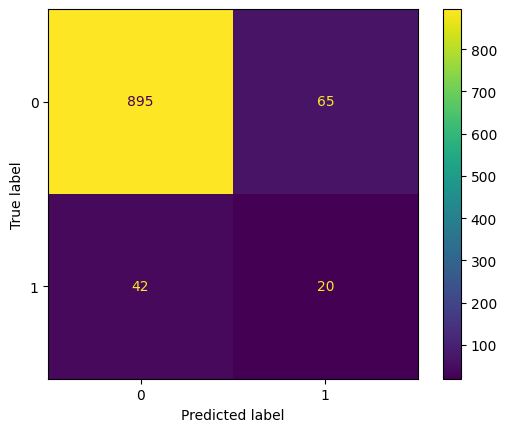

In [44]:
ConfusionMatrixDisplay.from_estimator(gb_model, X_test, y_test)

Text(0.5, 1.0, 'Feature Importance')

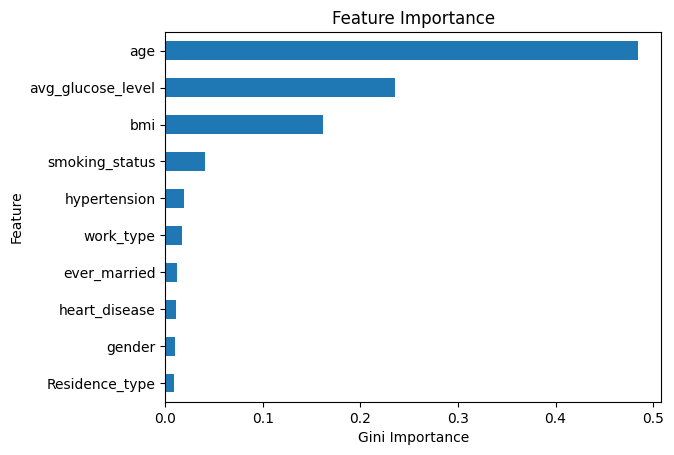

In [45]:
features = X_train_over.columns
# Extract importances from model
importances = gb_model.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")